In [1]:
import warnings; warnings.simplefilter('ignore')

import sys
sys.path.insert(0, '/home/jcbyts/Repos/')

import Utils as U
import gratings as gt


import NDN3.NDNutils as NDNutils

which_gpu = NDNutils.assign_gpu()
from scipy.ndimage import gaussian_filter
from copy import deepcopy

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt  # plotting
import seaborn as sns

import NDN3.NDN as NDN
import NDN3.Utils.DanUtils as DU

*******************************************************************************************
---> getting list of available GPUs:
[0, 1]

---> getting GPU memory map:
{0: 135, 1: 219}

---> setting up GPU with largest available memory:
   ...picking GPU # 0
*******************************************************************************************

Done!


In [2]:
# reload grating.py if you edited it
import importlib
importlib.reload(gt)

indexlist = [1]
matdat = gt.load_data(indexlist[0])

gt.list_sessions()

0      ellie_20170724
1      ellie_20170725
2      ellie_20170726
3      ellie_20170728
4      ellie_20170731
5      ellie_20170801
6      ellie_20170802
7      ellie_20170803
8      ellie_20170807
9      ellie_20170809
10     ellie_20170810
11     ellie_20170811
12    ellie_20170815a
13    ellie_20170815b
14     ellie_20170816
15     ellie_20170817
16     ellie_20170818
17     ellie_20170824
18     ellie_20170828
19     ellie_20180814
20     ellie_20181206
21     ellie_20181223
22     ellie_20181224
23     ellie_20190107
24     ellie_20190111
25      milo_20190607
26      milo_20190621
31     logan_20191202
32     logan_20191203
33     logan_20191204
34     logan_20191205
35     logan_20191206
41     logan_20191226
43     logan_20191230
44     logan_20191231
45     logan_20200106
46     logan_20200107
47     logan_20200109
48     logan_20200110
49     logan_20200115
50     logan_20200226
51     logan_20200228
52     logan_20200229
53     logan_20200302
54     logan_20200303
55     log

In [13]:
# load and process
indexlist = [5]
stim, sacon, sacoff, RobsAll, DF, basis, opts, sacbc, valid, eyepos = gt.load_and_setup(indexlist,npow=1.8)
RobsAll = RobsAll.astype('float32')

# valid indices
Ui = opts['Ui']
Xi = opts['Xi']

Tiv = np.intersect1d(opts['Ti'], np.where(valid)[0])

# need to include invalid indices for frozen trials
Ti = opts['Ti']

Robs = RobsAll.copy()
NC = Robs.shape[1]

maxmium SF: 14.17
16 selected
Found 16/16 units that had > 500 spikes


In [14]:
adam_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True}, learning_alg='adam')

early_stopping = 100

adam_params['batch_size'] = 1000
adam_params['display'] = 30
adam_params['MAPest'] = True
adam_params['epochs_training'] = 1000
adam_params['early_stop'] = early_stopping
adam_params['early_stop_mode'] = 1
adam_params['epsilon'] = 1e-8
adam_params['data_pipe_type'] = 'data_as_var' # 'feed_dict'
adam_params['learning_rate'] = 1e-3

lbfgs_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True, 'display': True}, learning_alg='lbfgs')
lbfgs_params['maxiter'] = 10000

noise_dist = 'poisson'
seed = 5
optimizer = 'adam'


if noise_dist=='poisson':
    null_adjusted = True
else:
    null_adjusted = False

if optimizer=='adam':
    opt_params = adam_params
else:
    opt_params = lbfgs_params

In [6]:
# fit stimulus model and remove bad units
num_tkerns = 3
num_lags = 15
NX = opts['NX']
NY = opts['NY']
NC = RobsAll.shape[1]

glm_par = NDNutils.ffnetwork_params(
    input_dims=[1,NX,NY], time_expand=[num_lags],
    layer_sizes=[num_tkerns, NC],
    layer_types=['temporal', 'normal'], # readout for cell-specific regularization
    act_funcs=['lin', 'softplus'],
    normalization=[1, 0],
    reg_list={'d2t': [1e-5], 'd2x': [None,1e-4], 'l2':[1e-6,1e-6]}
)

glm = NDN.NDN([glm_par], tf_seed=seed, noise_dist=noise_dist)

_ = glm.train(input_data=[stim], output_data=RobsAll, train_indxs=Ui, test_indxs=Xi,
    learning_alg=optimizer, opt_params=opt_params, use_dropout=False)

print("Done Training Initial Model")

LLx0 = glm.eval_models(input_data=[stim], output_data=RobsAll, data_indxs=Ti, nulladjusted=null_adjusted)

cids = LLx0>0.01
print("%d/%d units better than null model" %(np.sum(cids), len(LLx0)))
Robs = RobsAll[:,cids].copy()

W0509 12:38:57.415322 139994813298496 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:262: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0509 12:38:57.416695 139994813298496 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:270: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

W0509 12:38:57.417657 139994813298496 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:273: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0509 12:38:57.419074 139994813298496 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:1085: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0509 12:38:57.430522 139994813298496 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/layer.py:236: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead

Input dimensions: [1, 8, 6]
0: temporal (lin):  	[E3/I0] N
1: normal (softplus):  	[E41/I0] 


W0509 12:38:57.571248 139994813298496 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:1229: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0509 12:38:57.635610 139994813298496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0509 12:38:57.711495 139994813298496 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:336: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0509 12:38:57.722831 139994813298496 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:339: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



Epoch 0000:  avg train cost =    34.2619,  avg test cost =    34.3968,  reg penalty =     0.0027
Epoch 0029:  avg train cost =     5.9978,  avg test cost =     6.2806,  reg penalty =     0.0057
Epoch 0059:  avg train cost =     5.1722,  avg test cost =     5.4136,  reg penalty =     0.0048
Epoch 0089:  avg train cost =     4.5827,  avg test cost =     4.7989,  reg penalty =     0.0065
Epoch 0119:  avg train cost =     4.3987,  avg test cost =     4.6120,  reg penalty =     0.0079
Epoch 0149:  avg train cost =     4.3573,  avg test cost =     4.5689,  reg penalty =     0.0082
Epoch 0179:  avg train cost =     4.3482,  avg test cost =     4.5574,  reg penalty =     0.0081
Epoch 0209:  avg train cost =     4.3457,  avg test cost =     4.5553,  reg penalty =     0.0081
Epoch 0239:  avg train cost =     4.3444,  avg test cost =     4.5551,  reg penalty =     0.0081
Epoch 0269:  avg train cost =     4.3436,  avg test cost =     4.5549,  reg penalty =     0.0081

*** early stop criteria met..

## Fit GLM stimulus model (good units only)

In [6]:
num_lags = 15
NX = opts['NX']
NY = opts['NY']
NT,NC=Robs.shape
print("%d Time points, %d Neurons" %(NT, NC))

glm_par = NDNutils.ffnetwork_params(
    input_dims=[1,NX,NY], time_expand=[num_lags],
    layer_sizes=[num_tkerns, NC],
    layer_types=['temporal', 'normal'], # readout for cell-specific regularization
    act_funcs=['lin', 'softplus'],
    normalization=[1, 0],
    reg_list={'d2t': [1e-5], 'd2x': [None,1e-4], 'l2':[1e-6,1e-6]}
)

glm = NDN.NDN([glm_par], tf_seed=seed, noise_dist=noise_dist)

_ = glm.train(input_data=[stim], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
    learning_alg=optimizer, opt_params=opt_params, use_dropout=False)

print("Done Training Initial Model")

LLx0 = glm.eval_models(input_data=[stim], output_data=Robs, data_indxs=Ti, nulladjusted=null_adjusted)


121392 Time points, 22 Neurons
Input dimensions: [1, 8, 7]
0: temporal (lin):  	[E3/I0] N
1: normal (softplus):  	[E22/I0] 
Done Training Initial Model


In [8]:
def cart2pol(x, y):
    rho = np.hypot(x,y)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

NT,NC=Robs.shape

num_onlags = 70
num_offlags = 80
back_shiftson = 40
back_shiftsoff = 20

# valid = np.logical_and(~np.isnan(eyepos[:,1]), valid)
# # sacbc[~valid] = 0
v = np.intersect1d(np.where(np.logical_or(np.isnan(eyepos[:,1]), np.isnan(eyepos[:,2])))[0], np.where(~valid)[0])
# invalid = np.setdiff1d(np.arange(0,len(sacbc),1), valid)
sacbc[v]=0

sacbc[0] = 0
sacbc[-1] = 0
ixon = np.where(np.diff(sacbc, axis=0)==1)[0]
ixoff = np.where(np.diff(sacbc, axis=0)==-1)[0]
sacon = np.append(0, np.diff(sacbc, axis=0)==1).astype('float32')
sacoff = np.append(0, np.diff(sacbc, axis=0)==-1).astype('float32')

In [9]:
ixon = np.where(np.diff(sacbc, axis=0)==1)[0]-1
ixoff = np.where(np.diff(sacbc, axis=0)==-1)[0]-1
sacon = np.append(0, np.diff(sacbc, axis=0)==1).astype('float32')
sacoff = np.append(0, np.diff(sacbc, axis=0)==-1).astype('float32')

dx = eyepos[ixoff,1]-eyepos[ixon,1]
dy = eyepos[ixoff,2]-eyepos[ixon,2]

[sacAmp, th] = cart2pol(dx, dy)

from scipy.stats import multivariate_normal

# get the saccade 
x = np.concatenate([[dx], [dy]]).T
mu = opts['rf']['mu']

# mu = np.array( (1.1, -1.5))
print(mu)

mvn = multivariate_normal(mu, opts['rf']['cov'])
mvnOpp = multivariate_normal(-mu, opts['rf']['cov'])
sacInRF = mvn.pdf(x)
sacInRF = sacInRF / np.nanmax(sacInRF)
sacOppRF = mvnOpp.pdf(x)
sacOppRF = sacOppRF / np.nanmax(sacOppRF)


[ 1.49306135 -1.13889231]


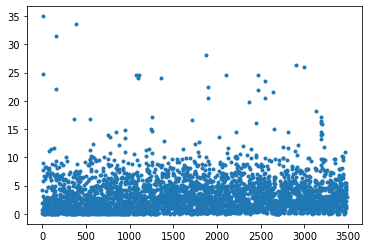

In [10]:
# f = plt.hist(sacAmp, bins=np.linspace(0, 5, 100))

# what's up with the tiny saccades
plt.plot(sacAmp, '.')



0
387
387
387
387
387
387
387
387
386


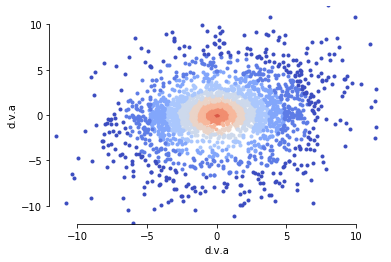

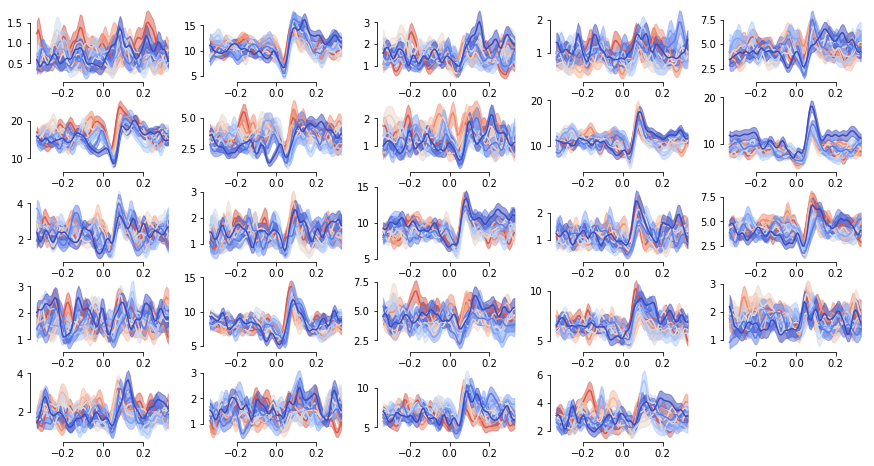

In [11]:
# Sort by saccade size
nsteps = 10
sacAmp[np.isnan(sacAmp)]=0
bins = np.percentile(sacAmp, np.linspace(0, 100, nsteps))
ind = np.digitize(sacAmp, bins)
cmap = plt.cm.coolwarm_r(np.linspace(0, 1, nsteps))
for i in range(nsteps):
    ix = ind==i
    print(sum(ix))
    plt.plot(dx[ix], dy[ix], '.', color=cmap[i])
plt.xlim([-12, 12])
plt.ylim([-12, 12])
sns.despine(trim=True)
plt.xlabel('d.v.a')
plt.ylabel('d.v.a')

ev = np.where(sacon)[0]

plt.figure(figsize=(15,8))
sx,sy = U.get_subplot_dims(NC)
win = [-40, 40]
for cc in range(NC):
    plt.subplot(sy,sx,cc+1)
    for i in range(nsteps):
        ix = ind==i
        rsmooth = gaussian_filter(Robs[:,cc], 1.5)*opts['frate']
        m,xax,wf = gt.psth(rsmooth, ev[ix], win[0], win[1])
        s = np.std(wf, axis=0)/np.sqrt(sum(ix))
        xax = np.asarray(xax)/opts['frate']
        plt.plot(xax, m, color=cmap[i])
        plt.fill_between(xax, m-s, m+s, color=cmap[i], alpha=.5)
    
sns.despine(trim=True)

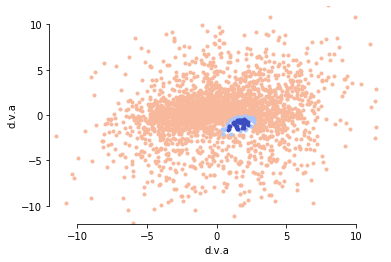

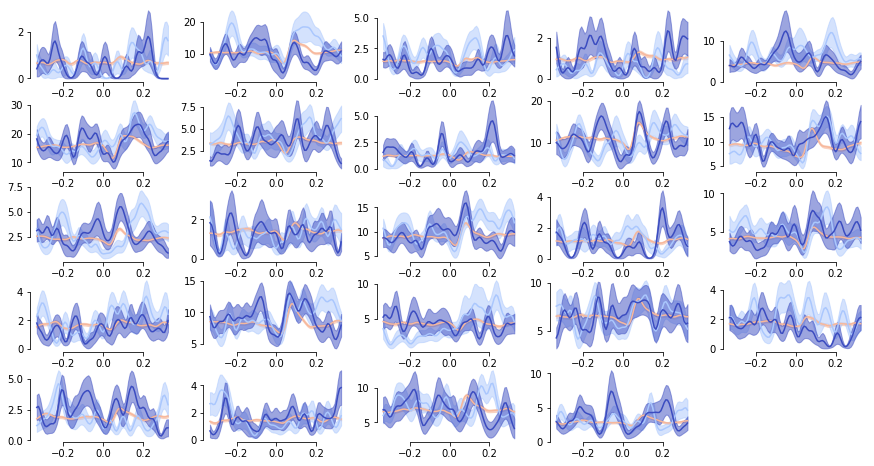

In [12]:
# Sort by saccade into the RF
bins = [0, 0.2, .5, 1]
nsteps = len(bins)
ind = np.digitize(sacInRF, bins)
cmap = plt.cm.coolwarm_r(np.linspace(0, 1, nsteps))
for i in range(nsteps):
    ix = ind==i
    plt.plot(dx[ix], dy[ix], '.', color=cmap[i])
plt.xlim([-12, 12])
plt.ylim([-12, 12])
sns.despine(trim=True)
plt.xlabel('d.v.a')
plt.ylabel('d.v.a')

ev = np.where(sacon)[0]

plt.figure(figsize=(15,8))
sx,sy = U.get_subplot_dims(NC)
win = [-40, 40]
for cc in range(NC):
    plt.subplot(sy,sx,cc+1)
    for i in range(nsteps):
        ix = ind==i
        rsmooth = gaussian_filter(Robs[:,cc], 2)*opts['frate']
        m,xax,wf = gt.psth(rsmooth, ev[ix], win[0], win[1])

        xax = np.asarray(xax)/opts['frate']
        s = np.std(wf, axis=0)/np.sqrt(sum(ix))
        plt.plot(xax, m, color=cmap[i])
        plt.fill_between(xax, m-s, m+s, color=cmap[i], alpha=.5)
    
sns.despine(trim=True)

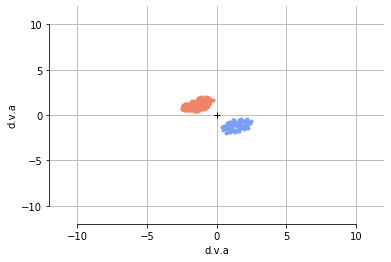

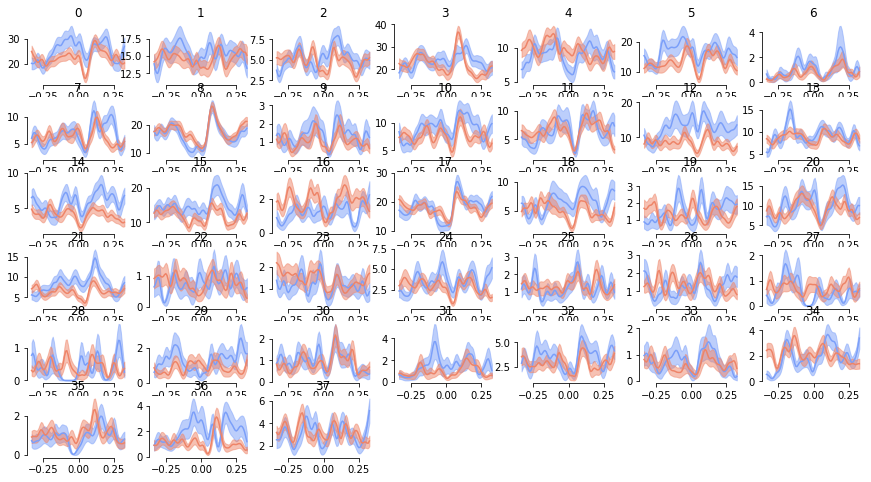

In [64]:
Rpred0 = glm.generate_prediction(input_data=[stim])

ind = np.ones(len(sacInRF))*10
ind[sacInRF>0.5]=0
ind[sacOppRF>0.5]=1

cmap = plt.cm.coolwarm(np.linspace(0, 1, 6))
cmap = cmap[[1,4]]

for i in range(2):
    ix = ind==i
    plt.plot(dx[ix], dy[ix], '.', color=cmap[i])
plt.xlim([-12, 12])
plt.ylim([-12, 12])
sns.despine(trim=True)
plt.xlabel('d.v.a')
plt.ylabel('d.v.a')
plt.plot(0,0,'+k')
plt.grid("on")

ev = np.where(sacon)[0]

plt.figure(figsize=(15,8))
sx,sy = U.get_subplot_dims(NC)
win = [-40, 40]
roc = np.zeros(NC)

for cc in range(NC):
    wfs = list()
    r = Robs[:,cc]# - Rpred0[:,cc]
    
    plt.subplot(sy,sx,cc+1)
    for i in range(2):
        ix = ind==i
        
        rsmooth = gaussian_filter(r, 2)*opts['frate']
        m,xax,wf = gt.psth(rsmooth, ev[ix], win[0], win[1])
        wfs.append(wf)
        s = np.std(wf, axis=0)/np.sqrt(sum(ix))
        xax = np.asarray(xax)/opts['frate']
        plt.plot(xax, m, color=cmap[i])
        plt.fill_between(xax, m-s, m+s, color=cmap[i], alpha=.5)

    plt.title(cc)
    
#     ii = np.logical_and(xax > -.1, xax < 0.04)
#     c1 = np.average(wfs[0][:,ii],axis=1)
#     c2 = np.average(wfs[1][:,ii],axis=1)
#     c1 = c1[c1>0]
#     c2 = c2[c2>0]
#     cnt1,bins1=np.histogram(c1, 100)
#     cnt2,bins2=np.histogram(c2, 100)
#     plt.bar(bins1[:-1], cnt1)
#     plt.bar(bins2[:-1], -cnt2)
        
sns.despine(trim=True)

IndexError: index 22 is out of bounds for axis 1 with size 22

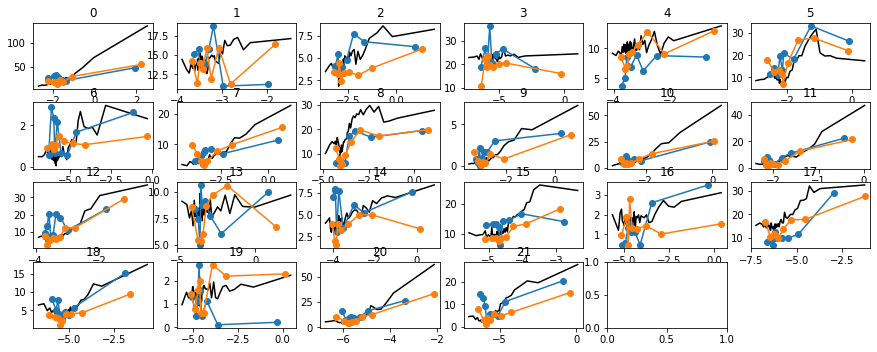

In [67]:
Rpred0 = glm.generate_prediction(input_data=[stim], pre_activation=True)

ind = np.ones(len(sacInRF))*10
ind[sacInRF>0.5]=0
ind[sacOppRF>0.5]=1

ev = np.where(sacon)[0]

plt.figure(figsize=(15,10))
sx,sy = U.get_subplot_dims(NC)
win = [-5, 2]

for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    r = Robs[:,cc]
    g = Rpred0[:,cc]
    spkNL,binEdges = empiricalNonlinearity(g,r*opts['frate'])
    plt.plot(binEdges, spkNL, 'k')
    rsmooth = gaussian_filter(r, 2)*opts['frate']

    m,xax,wf = gt.psth(rsmooth, ev, win[0], win[1])
    m,xax,gf = gt.psth(g, ev, win[0], win[1])
        
#     mw = np.mean(wf,axis=1)
#     gw = np.mean(gf,axis=1)

    mw = wf[ind==0,:].flatten()
    gw = gf[ind==0,:].flatten()
    spkNL,binEdges = empiricalNonlinearity(gw, mw,nbins=10)
    plt.plot(binEdges, spkNL, '-o')
    mw = wf[ind==1,:].flatten()
    gw = gf[ind==1,:].flatten()
    spkNL,binEdges = empiricalNonlinearity(gw, mw,nbins=10)
    plt.plot(binEdges, spkNL, '-o')
    plt.title(cc)




In [ ]:
cc = 14

r = Robs[:,cc]
g = Rpred0[:,cc]

# spkNL,binEdges = empiricalNonlinearity(g,r*opts['frate'])
#     plt.plot(binEdges, spkNL, 'k')
# rsmooth = gaussian_filter(r, 2)*opts['frate']

m,xax,wf = gt.psth(r, ev, win[0], win[1])
m,xax,gf = gt.psth(g, ev, win[0], win[1])
        
#     mw = np.mean(wf,axis=1)
#     gw = np.mean(gf,axis=1)


mw = wf[ind==0,:].flatten()
gw = gf[ind==0,:].flatten()
plt.plot(gw, mw, 'o')

mw = wf[ind==10,:].flatten()
gw = gf[ind==10,:].flatten()
plt.plot(gw, mw, 'o')

gw = sm.add_constant(gw)

poiss_model = sm.GLM(mw, gw,family=sm.families.Poisson())

poiss_results = poiss_model.fit()

print(poiss_results.summary())


# iin = np.argsort(gw[:,1])
# plt.plot(mw[iin], '.')

# plt.plot(ind, '.')

In [110]:
sum(ind==10)

4206

In [ ]:
import statsmodels.api as sm

data = sm.datasets.scotland.load(as_pandas=False)

data.exog = sm.add_constant(data.exog)

gamma_model = sm.GLM(data.endog, data.exog, family=sm.families.Gamma())

gamma_results = gamma_model.fit()

In [86]:
data.endog.shape

(32,)

NameError: name 'Rpred0' is not defined

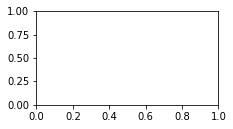

In [114]:

ev = np.where(sacon)[0]

win = [-40,40]
NC = Robs.shape[1]
sx,sy = U.get_subplot_dims(NC)
plt.figure(figsize=(15,10))
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    m,xax,wf = gt.psth(Robs[:,cc], ev, win[0], win[1])
    m0,xax,wf0 = gt.psth(Rpred0[:,cc], ev, win[0], win[1])
    m1,xax,wf1 = gt.psth(Rpred1[:,cc], ev, win[0], win[1])
    
#     plt.plot(xax, np.std(wf, axis=0), 'k')
#     plt.plot(xax,np.std(wf0, axis=0))
#     plt.plot(xax,np.std(wf1, axis=0))
    
    plt.plot(xax, m, 'k')
    plt.plot(xax,m0)
    plt.plot(xax,m1)

sns.despine(offset=0, trim=True)

### Spent some time trying to diagnose belew, but didn't get anywhere

In [66]:
cc = 2
nbins = 50
def empiricalNonlinearity(g, r, nbins=50):
    if type(nbins)!=int:
        binEdges = nbins
        nbins = len(binEdges)
    else:    
        binEdges = np.percentile(g, np.linspace(0, 100, nbins))
        
    id = np.digitize(g, binEdges)
    spkNL = np.zeros(nbins)
    for i in range(nbins):
        spkNL[i]=np.average(r[id==i])
    return spkNL,binEdges

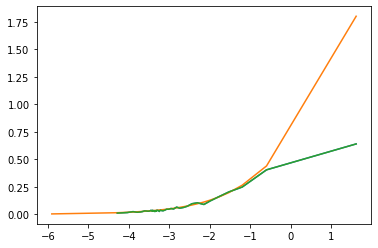

In [73]:
cc += 1
spkNL,binEdges = empiricalNonlinearity(g0[:,cc], Robs[:,cc])

plt.plot(binEdges, spkNL)
plt.plot(binEdges, np.log(1 + np.exp(binEdges)))

spkNL,binEdges = empiricalNonlinearity(g0[:,cc], Robs[:,cc], nbins=binEdges)    
plt.plot(binEdges, spkNL)

array([0.544598], dtype=float32)

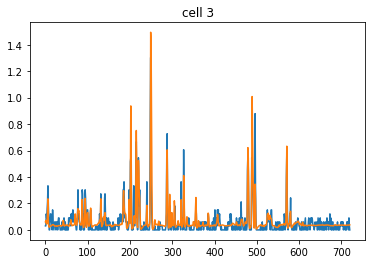

In [74]:
cc=3
Ti = opts['Ti']
r = np.reshape(Robs[Ti,cc], (opts['num_repeats'],-1))
r0 = np.reshape(Rpred1[Ti,cc], (opts['num_repeats'],-1))
r = np.average(r, axis=0)
r0 = np.average(r0, axis=0)
plt.plot(r)
plt.plot(r0)
plt.title("cell %d" %cc)
U.r_squared(np.reshape(r, (-1,1)), np.reshape(r0, (-1,1)))

In [75]:
g0 = glm.generate_prediction(input_data=[stim], pre_activation=True)

In [ ]:
cc=3
plt.plot(g0[1:1000,cc])

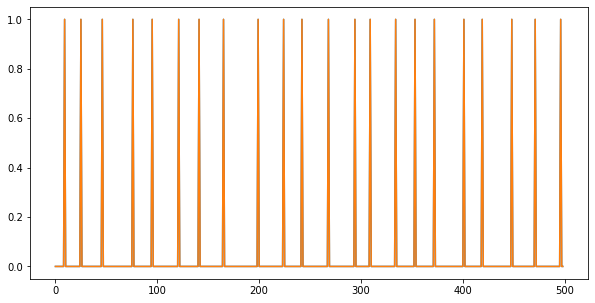

In [10]:
# check that saccade alignment works
win = [-50, 50]

# get alignment and sorting
ixon = np.where(np.diff(sacbc, axis=0)==1)[0]
ixoff = np.where(np.diff(sacbc, axis=0)==-1)[0]
tmp = np.append(0, np.diff(sacbc, axis=0)==1).astype('float')
# tmp[valid==0]=0

plt.figure(figsize=(10,5))
plt.plot(sacon[1:500])
plt.plot(tmp[1:500])
ev = ixon

sor,xax,sacs = gt.psth(sacbc.flatten(), ev, win[0], win[1])

ixd = np.argmin(np.array(xax)**2)
sor[ixd] = 0
sacs[:,ixd]=0

n=sacs.shape[0]
sortnext = np.zeros(n)
sortprev = np.zeros(n)
for i in range(n):
    a = sacs[i,:ixd]
    b = a[::-1]
    sortprev[i] = len(b) - np.argmax(b) - 1
    a = sacs[i,ixd:]
    sortnext[i] = np.argmax(a)

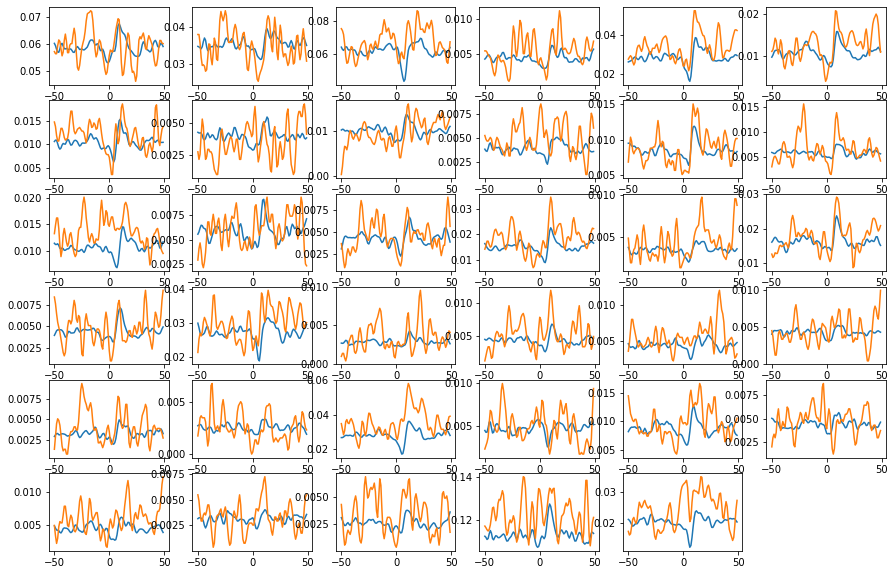

In [63]:
# saccade sorting



ixon = np.where(np.diff(sacbc, axis=0)==1)[0]
ixoff = np.where(np.diff(sacbc, axis=0)==-1)[0]
tmp = np.append(0, np.diff(sacbc, axis=0)==1).astype('float')

dx = eyepos[ixoff,1]-eyepos[ixon,1]
dy = eyepos[ixoff,2]-eyepos[ixon,2]
# plt.plot(dx, dy, '.')

[th, rho] = cart2pol(dx, dy)

mu = [1.5,1.5]
sigma = .5
d = np.exp(- ((dx - mu[0])**2/2/sigma**2 + (dy - mu[1])**2/2/sigma**2))

NC = Robs.shape[1]
sx,sy = U.get_subplot_dims(NC)
plt.figure(figsize=(15,10))
for cc in range(NC):
# Robs = RobsAll.copy()
    Rsmo = Robs[:,cc].flatten()
    _,xax,wf = gt.psth(Rsmo, ev, win[0], win[1])
    
    plt.subplot(sx,sy,cc+1)
    x = np.average(wf[d<.01,:], axis=0)
    x = convolve1d(x, np.hanning(7)/7, axis=0)
    plt.plot(xax, x)
    
    x = np.average(wf[d>.05,:], axis=0)
    x = convolve1d(x, np.hanning(7)/7, axis=0)
    plt.plot(xax, x)

In [70]:
cc=2
# Robs = RobsAll.copy()
Rsmo = Robs[:,cc].flatten()
_,xax,wf = gt.psth(Rsmo, ev, win[0], win[1])
# _,_,gf = gt.psth(g0[:,cc],ev,win[0],win[1])
_,_,spdwf = gt.psth(eyepos[:,3],ev,win[0],win[1])

plt.figure(figsize=(15,5))

# plt.subplot(1,3,1)
# ind = np.argsort(np.cos(th))
ind = np.argsort(d)
# ind = np.argsort(sortprev)
# ind = np.argsort(sortnext)

# ind1 = ind[0:500]
# ind2 = ind[-500:]
plt.imshow(sacs[ind,:], aspect='auto')
plt.title("Saccades Aligned to Saccade Onset")

# plt.subplot(1,3,2)
plt.imshow(wf[ind,:]>0,aspect='auto', interpolation='bicubic')
plt.title("Binned Spikes")

plt.subplot(1,3,3)
# plt.imshow(gf[ind,:]>0,aspect='auto', interpolation='bicubic')
plt.title("Generator Signal")

# plt.subplot(1,3,3)
# plt.plot(xax, np.average(wf, axis=0)*120, 'k')
# # plt.plot(xax, np.average(wf[ind1,:], axis=0)*120)
# # plt.plot(xax, np.average(wf[ind2,:], axis=0)*120)
# plt.title(cc)
# # cc=3 # set to return to example cell
sns.despine(offset=0, trim=True)

NameError: name 'sacs' is not defined

<Figure size 1080x360 with 0 Axes>

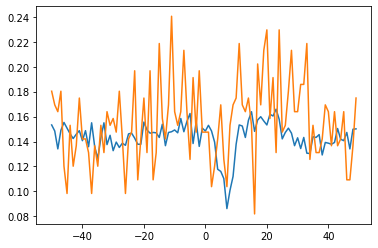

In [56]:
a = wf[ind,:]

# plt.plot(xax, np.average(a[1:1000,:], axis=0))
# plt.plot(np.average(a[500:1000,:], axis=0))
# plt.plot(xax, np.average(a[-1000:,:], axis=0))

plt.plot(xax, np.average(wf[d<.05,:], axis=0))
plt.plot(xax, np.average(wf[d>.05,:], axis=0))

In [24]:
spkNL,binEdges = empiricalNonlinearity(gf.flatten(), wf.flatten(), nbins=20)

# exclusion = [[-50, -15], [-20, 0], [-10, 10], [0, 20]]
# w = [[-20,-10],[-10,0], [0,5], [5,10]]

exlusion=[[-20, 0]]
w = [[-10,0]]
for i in range(len(w)):
    xax = np.array(xax)
    iix = np.logical_and(xax > w[i][0], xax < w[i][1])
    xix = np.logical_and(xax > exclusion[i][0], xax < exclusion[i][1])
    iiy = np.sum(spdwf[:,xix]>10, axis=1)==0
#     iiy = np.sum(sacs[:,xix]>10, axis=1)==0

    iiz = np.outer(iiy, iix)
    spkNL,binEdges = empiricalNonlinearity(gf[iiz], wf[iiz], nbins=50)
    plt.plot(binEdges, gaussian_filter(spkNL, .5))
    
# plt.plot(binEdges, np.log(1 + np.exp(binEdges)))

NameError: name 'empiricalNonlinearity' is not defined

In [162]:
w = [[-10,0], [0,5], [5,10]]
w[0]

[-10, 0]

In [ ]:
# tspaciin = np.arange

# snippet from Dan
# ndn3 = NDN.NDN([stim_par, sac_on_par, sac_off_par, sac_mid_par, comb_par], noise_dist='poisson')
# ndn3.networks[1].layers[0].init_temporal_basis( xs=tspacing )
# ndn3.networks[2].layers[0].init_temporal_basis( xs=tspacingOff )


sac_on_par = NDNutils.ffnetwork_params(
    input_dims=[1,1,1], time_expand=[num_onlags],
    xstim_n=[1],
    layer_sizes=[NC], # conv_filter_widths=[1],
    layer_types=['temporal'], act_funcs=['lin'],
    normalization=[0],
    reg_list={'d2t':[0.01],'l2':[None], 'l1':[None]})
sac_off_par = NDNutils.ffnetwork_params(
    input_dims=[1,1,1], time_expand=[num_offlags],
    xstim_n=[2],
    layer_sizes=[NC], # conv_filter_widths=[1],
    layer_types=['temporal'], act_funcs=['lin'],
    normalization=[0],
    reg_list={'d2t':[0.001],'l2':[None], 'l1':[None]})
comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,1,2], layer_sizes=[NC],
    layer_types=['add'], act_funcs=['softplus'])

# initialize NDN
ndn2 = NDN.NDN([stim_par, sac_on_par, sac_off_par, comb_par], noise_dist='poisson')
ndn2.networks[1].layers[0].init_temporal_basis( xs=tspacing )
ndn2.networks[2].layers[0].init_temporal_basis( xs=tspacingOff )